# Optimization Tutorial

Trey V. Wenger (c) September 2024

Here we demonstrate how to optimize the number of cloud components in a `EmissionAbsorptionModel` model.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.6.3+4.ga230ddc.dirty
caribou_hi version: 1.0.0-staging+1.g238726f.dirty


## Model Definition and Simulated Data

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-100.0, 100.0, 500) # km s-1
absorption_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1 # K
rms_absorption = 0.01 # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$"),
}

from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_emission = 0.1, # width of emission rms (K) prior
    prior_rms_absorption = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([20.0, 21.0, 20.5]),
    "log10_nHI": np.array([2.0, 0.0, 0.5]),
    "log10_tkin": np.array([2.5, 4.0, 3.5]),
    "log10_n_alpha": np.array([-6.0, -5.0, -6.0]),
    "log10_larson_linewidth": np.array([0.15, 0.2, 0.25]),
    "larson_power": np.array([0.5, 0.3, 0.3]),
    "velocity": np.array([0.0, -5.0, 5.0]),
}

sim_params_emission = sim_params.copy()
sim_params_emission["rms_emission"] = rms_emission
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["rms_absorption"] = rms_absorption
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$"),
}

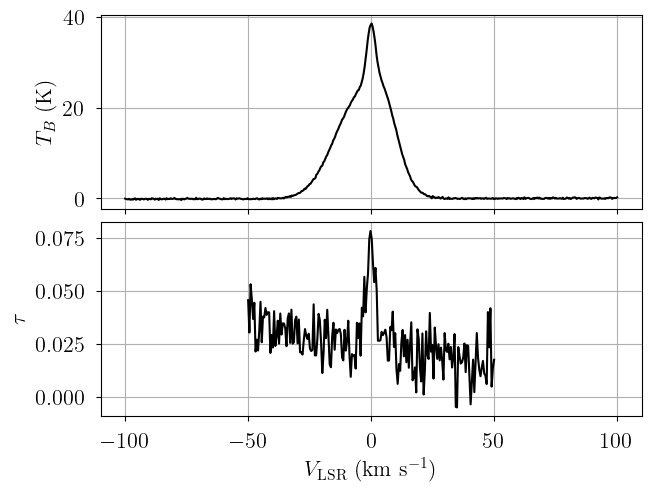

In [3]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    EmissionAbsorptionModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_emission = 0.1, # width of emission rms (K) prior
    prior_rms_absorption = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 2.665e+06
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 3400
Interrupted at 3,399 [3%]: Average Loss = 2.3015e+05


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 7.317e+02

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = 1.6261e+05


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.013e+02

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 2.5642e+05


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.594e+02

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = 1.0753e+05


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -1.810e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 1.1468e+05


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = -1.673e+03

Sampling best model (n_cloud = 4)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = 1.0753e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_nHI_norm, log10_tkin_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, velocity_norm, rms_emission_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1455 seconds.


There were 1158 divergences in converged chains.
GMM converged to unique solution


The "best" model is saved in `opt.best_model`. Note that the variational inference algorithm has determined that the optimal number of clouds is `n_cloud=4` when, in fact, we generated these data with `n_cloud=3`. Variational inference is only approximation and is ultimately sensitive to the tuning of the hyperparameters!

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 4


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.333,0.008,-0.345,-0.318,0.007,0.007,1.0,22.0,NaN
baseline_absorption_norm[1],-1.433,0.016,-1.455,-1.401,0.010,0.008,3.0,31.0,NaN
baseline_absorption_norm[2],1.731,0.150,1.501,2.020,0.131,0.130,1.0,11.0,NaN
baseline_emission_norm[0],-0.459,0.000,-0.460,-0.459,0.000,0.000,2.0,11.0,NaN
baseline_emission_norm[1],0.024,0.000,0.024,0.025,0.000,0.000,8.0,21.0,NaN
baseline_emission_norm[2],0.047,0.003,0.043,0.053,0.002,0.001,3.0,11.0,NaN
depth[0],49.238,1.485,46.936,51.653,0.769,0.593,4.0,35.0,NaN
depth[1],1.207,0.115,0.984,1.411,0.096,0.090,1.0,11.0,NaN
depth[2],1.017,0.133,0.869,1.353,0.048,0.036,10.0,15.0,NaN
depth[3],21.615,1.086,19.088,23.110,0.403,0.298,7.0,30.0,NaN


Sampling: [absorption, emission]


Output()

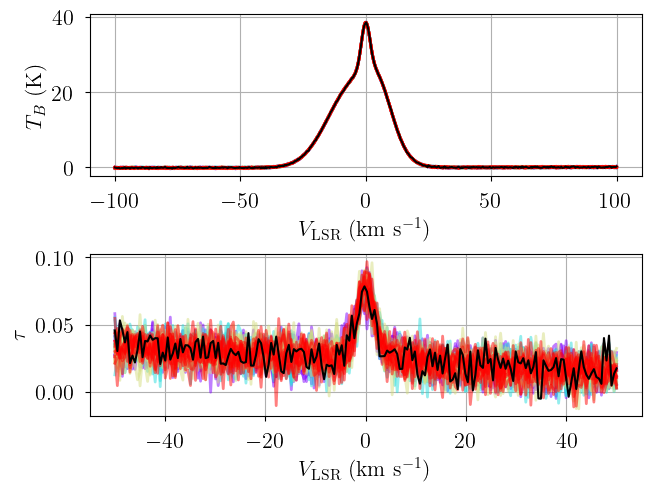

In [10]:
posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)